# ECMWF Open Data Access (Novice Level)

This notebook guides you through accessing and exploring ECMWF Open Data.

We'll use ECMWF-supported tools where possible, and keep the interface beginner-friendly with interactive widgets and clear steps.

Focus: **IFS HRES (High Resolution) Operational Forecasts**

---

## 1. Setup & Imports

We import essential libraries, prioritizing ECMWF packages (`earthkit`, `eccodes`).

In [1]:
import os
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from IPython.display import display, Markdown
import ipywidgets as widgets

# Optional: ECMWF-supported GRIB reader
from earthkit.data import from_source

## 2. Check Earthkit Installation

This cell checks that the `earthkit` package is installed correctly and prints its version.  
Earthkit combines data access (`earthkit.data`) and visualization (`earthkit.plots`) tools developed by ECMWF.
We check and print the library versions because plotting choices depend on installed versions.

Docs: [Earthkit Overview](https://earthkit.readthedocs.io)


In [2]:
import earthkit; print(earthkit.__version__)


0.11.2


## 3. Select Forecast to Download

We'll provide dropdowns to select the forecast date, run hour, model, and lead time.

Only `.grib2` forecast files are shown (index files are excluded).

In [10]:
BASE_URL = "https://data.ecmwf.int/forecasts/"

# --- Step 1: Fetch available forecast dates from ECMWF ---
r = requests.get(BASE_URL)
soup = BeautifulSoup(r.text, "html.parser")

available_dates = sorted([
    a.text.strip("/") for a in soup.find_all("a")
    if a.text.strip("/").isdigit() and len(a.text.strip("/")) == 8
], reverse=True)

model_dropdown = widgets.Dropdown(
    options=["0p25/oper", "0p25/enfo", "0p25/waef", "0p25/wave"],
    value="0p25/oper",
    description="Model:"
)

date_dropdown = widgets.Dropdown(
    options=available_dates,
    value=available_dates[0],
    description="Date:"
)

hour_dropdown = widgets.Dropdown(
    options=["00z", "06z", "12z", "18z"],
    value="00z",
    description="Model Run:"
)

forecast_dropdown = widgets.Dropdown(
    options=[],
    description="Forecast Step:",
)

def update_forecast_options(*_):
    folder_url = f"{BASE_URL}{date_dropdown.value}/{hour_dropdown.value}/ifs/{model_dropdown.value}/"
    try:
        r = requests.get(folder_url)
        soup = BeautifulSoup(r.text, "html.parser")
        grib_files = [a['href'] for a in soup.find_all("a") if a['href'].endswith(".grib2") and "index" not in a['href']]
        short_options = [(f.split("-")[1], os.path.basename(f)) for f in grib_files]  # ("0h", "filename")
        forecast_dropdown.options = short_options
    except Exception as e:
        forecast_dropdown.options = []
        print("Error fetching forecast list:", e)

date_dropdown.observe(update_forecast_options, names='value')
hour_dropdown.observe(update_forecast_options, names='value')
model_dropdown.observe(update_forecast_options, names='value')

update_forecast_options()

display(widgets.VBox([date_dropdown, hour_dropdown, model_dropdown, forecast_dropdown]))

## 4. Download Selected Forecast Data

Once a file is selected, click to download it to the `../data` folder.

In [ ]:
download_button = widgets.Button(description="⬇️ Download GRIB File", button_style="primary")
download_output = widgets.Output()

def handle_download(_):
    download_output.clear_output()
    with download_output:
        date, hour, model, file_name = date_dropdown.value, hour_dropdown.value, model_dropdown.value, forecast_dropdown.value
        folder_url = f"{BASE_URL}{date}/{hour}/ifs/{model}/"
        full_url = urljoin(folder_url, file_name)
        os.makedirs("../data", exist_ok=True)
        local_path = os.path.join("../data", os.path.basename(file_name))
        print(f"📄 Selected: {file_name}")
        print(f"🔗 URL: {full_url}")

        if not os.path.exists(local_path):
            print("⬇️ Downloading...")
            with requests.get(full_url, stream=True) as r:
                r.raise_for_status()
                with open(local_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"✅ File saved to: {local_path}")
        else:
            print(f"✅ File already exists: {local_path}")

        globals()['local_path'] = local_path

download_button.on_click(handle_download)
display(download_button, download_output)

Button(button_style='primary', description='⬇️ Download GRIB File', style=ButtonStyle())

Output()

## 5. Load and Explore Forecast Data

We'll use `earthkit.data` to load the file.

In [12]:
# Load GRIB using earthkit
ds = from_source("file", local_path)
ds.describe()

,,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,,
100u,heightAboveGround,100,20250804,0,102,None,228246,od,oper,fc,0001
100v,heightAboveGround,100,20250804,0,102,None,228247,od,oper,fc,0001
10u,heightAboveGround,10,20250804,0,102,None,165,od,oper,fc,0001
10v,heightAboveGround,10,20250804,0,102,None,166,od,oper,fc,0001
2d,heightAboveGround,2,20250804,0,102,None,168,od,oper,fc,0001
2t,heightAboveGround,2,20250804,0,102,None,167,od,oper,fc,0001
asn,surface,0,20250804,0,102,None,32,od,oper,fc,0001
d,isobaricInhPa,"100,200,...",20250804,0,102,None,155,od,oper,fc,0001
ewss,surface,0,20250804,0,102,None,180,od,oper,fc,0001


## 6. Plot Forecast Data with Earthkit

We use `earthkit.data.from_source` to load the downloaded GRIB data.  
This creates a dataset object (`ds`) that holds all forecast fields (variables, levels, and metadata) in memory.

To quickly visualise the contents, we use `earthkit.plots.quickplot`, a convenient one-line function that creates a sensible default map.

### Available Parameters

ECMWF Open Data parameters are documented here:  
[https://www.ecmwf.int/en/forecasts/datasets/open-data](https://www.ecmwf.int/en/forecasts/datasets/open-data)

In this section, we’ll select one of these parameters (e.g., `2t` for 2m temperature) and plot it.


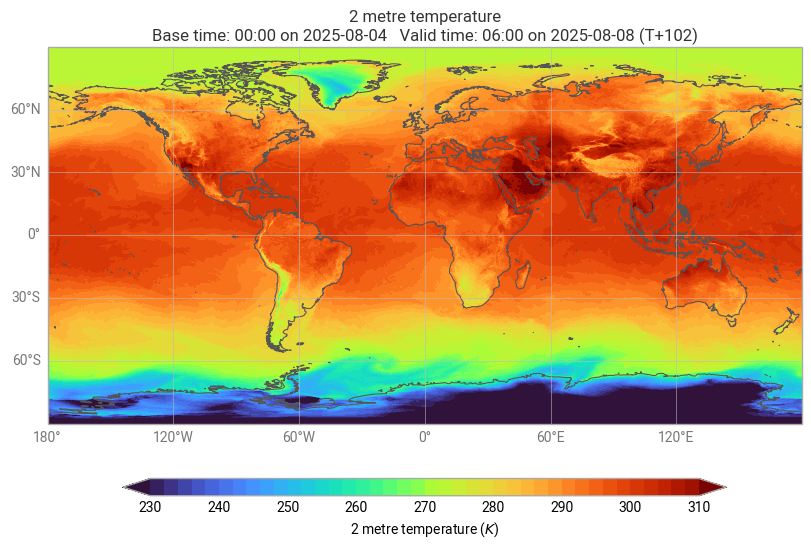

In [18]:
# Select the 2m temperature field (shortName = "2t")
t2m = ds.sel(shortName="2t")[0]

earthkit.plots.quickplot(t2m)
